## Recuperación de Información
# Práctica 3.3 &mdash; Búsqueda Web y Recomendación - Sistemas de Recomendación
### Autores: Alvaro Alvarez y Bayron Portuguez

# 3.  Parte 3

Conjunto de librerías a utilizar en el NoteBook.

In [ ]:
# Instalar Surprise si no está instalado
#!pip install surprise

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score,precision_recall_fscore_support
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from surprise import accuracy
from surprise.model_selection import cross_validate

En esta práctica se usará un dataset (dividido en entrenamiento y test) que se obtendrá de la siguiente manera, una vez que hayáis rellenado vuestros gustos por las películas que se indican en la siguiente hoja de cálculo:
https://docs.google.com/spreadsheets/d/1YmCY-T0ByZRXz8DpaFyieGfsS2jvxsprZr5dsSh8mpE/edit?usp=sharing

Una vez completo, en las pestañas *ratings_training* y *ratings_test* se encontrarán los datos (tripletas <usuario, item, rating>) a utilizar en el resto de la práctica.

Observación: usamos DataFrames por comodidad, pero implementaciones más eficientes podrían hacer uso de las [matrices dispersas](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) de SciPy u otras estructuras de datos que consideréis convenientes.

In [ ]:
import pandas as pd

SHEET_ID = '1YmCY-T0ByZRXz8DpaFyieGfsS2jvxsprZr5dsSh8mpE'
SHEET_NAME = 'ratings_training'
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME}'
df_training = pd.read_csv(url)
print(df_training.head())
SHEET_NAME = 'ratings_test'
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME}'
df_testing = pd.read_csv(url)
print(df_testing.head())

   user  item  rating
0     0    18     4.0
1     0    74     4.0
2     0    62     4.0
3     0    47     4.0
4     0    11     3.0
   user  item  rating
0     0   140     4.0
1     0   104     4.0
2     0   123     3.0
3     0   145     3.5
4     0    63     4.0


## 3.1 Implementar algoritmo de recomendación

Aplicar un algoritmo de filtrado colaborativo basado en memoria para generar recomendaciones de películas para cada estudiante. La estrategia a usar será a elección de cada estudiante, teniendo en cuenta las consideraciones vistas en clase. Aplicarlo utilizando las puntuaciones de entrenamiento como base para recomendar películas del conjunto de test, y observar el nivel de acierto (visualmente, comparando puntuación real de test y predicción del recomendador).

In [ ]:
def collaborative_filtering_user_based(train_data, test_data, k_neighbors):
    # Crear matrices de usuario-item para entrenamiento y prueba
    train_matrix = train_data.pivot(index='user', columns='item', values='rating').fillna(0)
    test_matrix = test_data.pivot(index='user', columns='item', values='rating').fillna(0)

    # Entrenar el modelo de KNN
    model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=k_neighbors)
    model.fit(train_matrix)

    # Encontrar los vecinos más cercanos para cada usuario
    distances, indices = model.kneighbors(train_matrix)

    # Inicializar matrices para almacenar predicciones
    pred_matrix = np.zeros(train_matrix.shape)

    # Hacer predicciones para cada usuario
    for i in range(len(train_matrix)):
        # Calcular la media de las calificaciones del usuario
        user_mean_rating = np.mean(train_matrix.iloc[i,:])
        # Inicializar una lista para almacenar las predicciones para el usuario actual
        user_predictions = []
        # Calcular la suma de las similitudes de los vecinos más cercanos
        sim_sum = np.sum(distances[i])
        # Para cada vecino más cercano, calcular la calificación predicha
        for j in range(1, k_neighbors):
            neighbor_index = indices[i, j]
            neighbor_similarity = distances[i, j]
            neighbor_ratings = train_matrix.iloc[neighbor_index,:]
            neighbor_mean_rating = np.mean(neighbor_ratings)
            user_predictions.append((neighbor_similarity / sim_sum) * (neighbor_ratings - neighbor_mean_rating))
        # Sumar las predicciones de todos los vecinos
        user_predictions = np.sum(user_predictions, axis=0)
        # Agregar las predicciones a la matriz de predicciones
        pred_matrix[i,:] = user_mean_rating + user_predictions

    # Filtrar predicciones solo para las entradas existentes en el conjunto de prueba
    pred_ratings = pred_matrix[test_matrix.values.nonzero()]
    true_ratings = test_matrix.values[test_matrix.values.nonzero()]

    # Calcular métricas de evaluación
    rmse = np.sqrt(mean_squared_error(true_ratings, pred_ratings))
    mae = mean_absolute_error(true_ratings, pred_ratings)

    # Calcular precision y recall
    threshold = 3.5
    pred_binary = np.where(pred_ratings >= threshold, 1, 0)
    true_binary = np.where(true_ratings >= threshold, 1, 0)
    precision = precision_score(true_binary, pred_binary)
    recall = recall_score(true_binary, pred_binary)

    return mae, rmse, precision, recall

## 3.2 Evaluación

Calcular el MAE y RMSE de las recomendaciones producidas. Contrastar los resultados (MAE y RMSE) de dos estrategias diferentes de recomendación (o de la misma estrategia con diferentes parámetros).

Calcular P@N (precisión) y R@N (recall) de las recomendaciones producidas a distintos N, considerando como relevantes aquellos ítems con un rating mayor que 3 en test. Para ello, tened en cuenta que habrá que predecir una puntuación (para cada usuario) usando todos los ítems del sistema excepto aquellos que ya ha visto en entrenamiento, ordenando dichas puntuaciones para generar el ranking.

**Respuesta:** Vamos a calcular el valor del MAE, RMSE, P@N y R@N del algoritmo del filtrado colaborativo basado en usuario:

In [ ]:
neighbors = [1, 3, 5, 7, 9]
results = []

for n in neighbors:
    mae, rmse, precision, recall = collaborative_filtering_user_based(df_training, df_testing, n)
    results.append([n, mae, rmse, precision, recall])

# Crear un DataFrame a partir de los resultados
results_df = pd.DataFrame(results, columns=["Vecinos", "MAE", "RMSE", "Precision", "Recall"])
results_df

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Vecinos,MAE,RMSE,Precision,Recall
0,1,2.022772,1.716566,0.000000,0.000000
1,3,2.343751,1.920919,0.659091,0.144279
2,5,2.242333,1.871149,0.677419,0.104478
3,7,2.197859,1.862996,0.548387,0.084577
4,9,2.161484,1.826988,0.629630,0.084577


## 3.3 Informe



Vamos ver los resultados de manera gráfica:

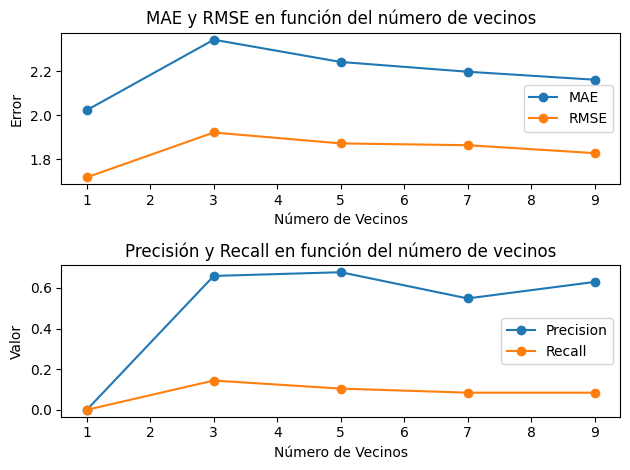

In [ ]:
# MAE y RMSE
plt.subplot(2, 1, 1)
plt.plot(results_df["Vecinos"], results_df["MAE"], marker='o', label='MAE')
plt.plot(results_df["Vecinos"], results_df["RMSE"], marker='o', label='RMSE')
plt.title('MAE y RMSE en función del número de vecinos')
plt.xlabel('Número de Vecinos')
plt.ylabel('Error')
plt.legend()

# Precisión y Recall
plt.subplot(2, 1, 2)
plt.plot(results_df["Vecinos"], results_df["Precision"], marker='o', label='Precision')
plt.plot(results_df["Vecinos"], results_df["Recall"], marker='o', label='Recall')
plt.title('Precisión y Recall en función del número de vecinos')
plt.xlabel('Número de Vecinos')
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()

Podemos observar que cuando se considera únicamente al vecino más proximo (n=1), el MAE y el RMSE son relativamente bajos, pero la precisión y el recall son cero. Esto sugiere que el modelo para un único vecino está sobreajustando los datos de entrenamiento y no generaliza bien para usuarios nuevos o películas no vistas.

A medida que se aumenta el número de vecinos (n), tanto MAe como RMSE aumentan ligeramente, lo que indica una ligera disminución en la precisión del modelo. En cambio, la precisión y el recall mejoran, lo que supondría que el modelo se generaliza mejor y es capaz de hacer predicciones más precisas para un conjunto más amplio de usuarios y películas.

## Opcional 3.A

Utilizar librerías (por ejemplo, Surprise o LightFM en Python) sobre los mismos datos para generar las recomendaciones y comparar con los resultados anteriores. Contrastar los valores de MAE y RMSE de las diferentes pruebas. Para cualquier duda o dificultad con este apartado consultar con el profesor.

Vamos a usar la librería **LightFM** de Python.

In [ ]:
reader = Reader(rating_scale=(1, 5))

# Carga el dataset desde los DataFrames
train_data = Dataset.load_from_df(df_training[['user', 'item', 'rating']], reader)
test_data = Dataset.load_from_df(df_testing[['user', 'item', 'rating']], reader)

# Construye el trainset y testset desde el dataset
trainset = train_data.build_full_trainset()
testset = test_data.build_full_trainset().build_testset()

# Rango de vecinos a probar
neighbor_range = [1, 3, 5, 7, 9]

results_sur = []

for k in neighbor_range:
    # Define el algoritmo de filtrado colaborativo basado en vecinos
    algo = KNNBasic(k=k, sim_options={'user_based': True})

    # Entrena el modelo
    algo.fit(trainset)

    # Realiza predicciones en el conjunto de prueba
    predictions = algo.test(testset)

    # Calcula y muestra el RMSE y MAE
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)

    # Convierte las calificaciones continuas en etiquetas binarias (0 o 1) usando un umbral
    threshold = 3.5
    true_labels = [1 if pred.r_ui >= threshold else 0 for pred in predictions]
    predicted_labels = [1 if pred.est >= threshold else 0 for pred in predictions]

    # Calcula la precisión y el recall
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)

    # Almacena los resultados en una lista
    results_sur.append([k, rmse, mae, precision, recall])

# Convierte los resultados en un DataFrame
results_df_sur = pd.DataFrame(results_sur, columns=['Vecinos', 'RMSE', 'MAE', 'Precisión', 'Recall'])
results_df_sur

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.1991
MAE:  0.9000
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0699
MAE:  0.8516
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0755
MAE:  0.8554
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0645
MAE:  0.8411
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0738
MAE:  0.8517


,Vecinos,RMSE,MAE,Precisión,Recall
0,1,1.199071,0.900000,0.661157,0.796020
1,3,1.069938,0.851628,0.711340,0.686567
2,5,1.075520,0.855353,0.712042,0.676617
3,7,1.064492,0.841073,0.725275,0.656716
4,9,1.073847,0.851687,0.704301,0.651741


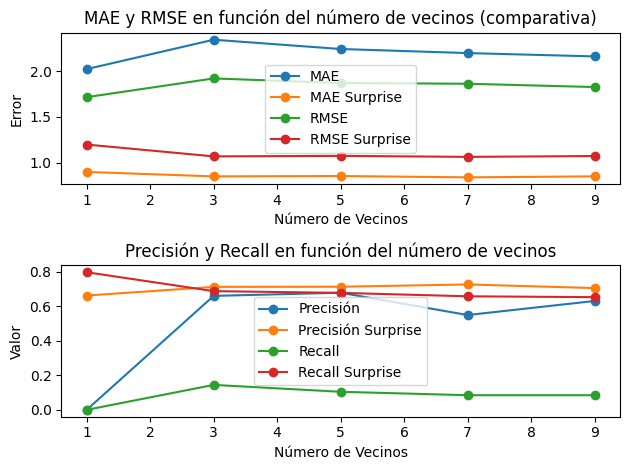

In [ ]:
# MAE y RMSE
plt.subplot(2, 1, 1)
plt.plot(results_df["Vecinos"], results_df["MAE"], marker='o', label='MAE')
plt.plot(results_df_sur["Vecinos"], results_df_sur["MAE"], marker='o', label='MAE Surprise')
plt.plot(results_df["Vecinos"], results_df["RMSE"], marker='o', label='RMSE')
plt.plot(results_df_sur["Vecinos"], results_df_sur["RMSE"], marker='o', label='RMSE Surprise')
plt.title('MAE y RMSE en función del número de vecinos (comparativa)')
plt.xlabel('Número de Vecinos')
plt.ylabel('Error')
plt.legend()

# Precisión y Recall
plt.subplot(2, 1, 2)
plt.plot(results_df["Vecinos"], results_df["Precision"], marker='o', label='Precisión')
plt.plot(results_df_sur["Vecinos"], results_df_sur["Precisión"], marker='o', label='Precisión Surprise')
plt.plot(results_df["Vecinos"], results_df["Recall"], marker='o', label='Recall')
plt.plot(results_df_sur["Vecinos"], results_df_sur["Recall"], marker='o', label='Recall Surprise')
plt.title('Precisión y Recall en función del número de vecinos')
plt.xlabel('Número de Vecinos')
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()

Como podemos observar en los resultados obtenidos en la última ejecución, se muestra una mejora significativa en el rendimiento del modelo en comparación con los resultados obtenidos anteriormente. La principales diferencias son:
* **RMSE y MAE** son considerablemente más bajos en comparación con los resultados obtenidos anteriormente. Esto indica que el modelo ha mejorado en términos de precisión en la predicción de las calificaciones de las películas.
* **Precisión y recall** son más altos en general, lo que sugiere que el modelo es mejor para identificar correctamente las recomendaciones relevantes para los usuarios.

En general, los últimos resultados indican un mejor rendimiento del modelo en comparación con los resultados anteriores.

## Opcional 3.B

Implementar un algoritmo de recomendación mediante factorización de matrices.

In [ ]:
# TODO

## Opcional 3.C

Implementar un algoritmo basado en contenido (usando los géneros de las películas como atributos).

In [ ]:
# TODO

## Opcional 3.D

Repetir alguno de los ejercicios con alguna colección de prueba (p.e., [MovieLens](https://grouplens.org/datasets/movielens/)).

In [ ]:
# TODO